# Testing KMEANS

In [118]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [2]:
X = np.load('electricity/data/electricity.npy')

In [5]:
X.shape

(370, 26136)

In [33]:
kmeans = KMeans(n_clusters=4, random_state=0, verbose=1)

In [34]:
kmeans.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 102873901883489.67
start iteration
done sorting
end inner loop
Iteration 1, inertia 102873901883489.67
center shift 0.000000e+00 within tolerance 2.056380e+04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 100503576375981.97
start iteration
done sorting
end inner loop
Iteration 1, inertia 96922555745849.94
start iteration
done sorting
end inner loop
Iteration 2, inertia 94522849433164.77
start iteration
done sorting
end inner loop
Iteration 3, inertia 94522849433164.77
center shift 0.000000e+00 within tolerance 2.056380e+04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 99626494053111.58
start iteration
done sorting
end inner loop
Iteration 1, inertia 94522849433164.77
start iteration
done sorting
end inner loop
Iteration 2, inertia 94522849433164.77
center shift 0.000000e+00 within tolerance 2.056380e+04
Initializa

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=1)

In [35]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [36]:
centers = kmeans.cluster_centers_

In [37]:
centers[:,15000:15168].shape

(4, 168)

In [38]:
d = {f"cluster_{i}" : l for i, l in enumerate(centers[:,15000:15168])}

In [39]:
df = pd.DataFrame(d)

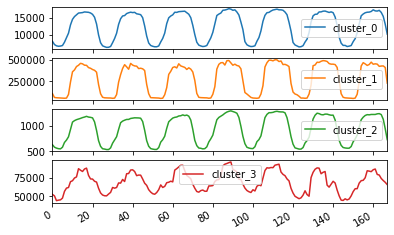

In [40]:
df.plot(subplots=True)
plt.show()

In [104]:
def shape_series(
    shape, length=100, period=10, mean=0, var=1, noise=None, noise_var=1
):
    """ Creates a shape series and adds noise to it. """
    assert shape in ["sine", "triangle", "square"]
    assert noise in [None, "iid", "matern"]
    if shape == "sine":
        s = sine(length, period, mean, var)
    elif shape == "square":
        s = square(length, period, mean, var)
    elif shape == "triangle":
        s = triangle(length, period, mean, var)
    if noise == "iid":
        s = iid_noise(s)
    elif noise == "matern":
        s = matern_noise(s)
    return s

def sine(t, p, mean=0, var=1, start=1):
    """ Creating a sine signal with period p. """
    x = np.linspace(1, t, t)
    s = np.sin(1 / p * x * 2 * np.pi)
    s = s * var + mean
    assert len(s) == t
    return s

def triangle(t, p, mean=0, var=1, start=1):
    """ Creating a triangle signal with period p. """
    y = np.array([(1 - 2 / p * x) for x in range(p)])
    s = np.tile(
        np.concatenate((start * y, -start * y), axis=None), t // (2 * p) + 1
    )[:t]
    s = s * var + mean
    assert len(s) == t
    return s

def square(t, p, mean=0, var=1, start=1):
    """ Creating a square signal that alternates every p step. """
    s = np.tile(
        np.concatenate((start * np.ones(p), -start * np.ones(p)), axis=None),
        t // (2 * p) + 1,
    )[:t]
    s = s * var + mean
    assert len(s) == t
    return s

def iid_noise(x, var=0.2):
    noise = var * np.random.randn(len(x))
    x += noise
    return x

def matern_noise(s, var=1, nu=1.5):
    """ nu determines the smoothness. smaller is less smooth """
    gp = GaussianProcessRegressor(
        kernel=var * Matern(length_scale=10, length_scale_bounds=(1e-5, 1e5), nu=nu)
    )
    x = np.linspace(1, len(s), len(s))
    sample = gp.sample_y(x.reshape(-1, 1), 1, random_state=None).flatten()

    return s + sample

In [105]:
def create_shape_series(
        N: int, t: int, balance: bool, mean: float = 0, var: float = 1.0
    ):
        ts = []
        descriptive = []
        for i in range(N):
            # Randomly choose shape, frequency and noise
            shape = np.random.choice(["sine", "square", "triangle"])
            noise = np.random.choice(["iid", "matern", None])
            period = np.random.choice([2, 10, 20])
            s = shape_series(
                shape, length=t, period=period, noise=noise, mean=mean, var=var
            )
            ts.append(s)
            descriptive.append([shape, noise, str(period)])

        df_ts = pd.DataFrame(ts)
        df_descriptive = pd.DataFrame(descriptive)
        df_descriptive.columns = ["shape", "noise", "period"]
        return df_ts, df_descriptive

In [106]:
df, _ = create_shape_series(N=1000, t=1000, mean=10, var=1.0, balance=False)

In [107]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,10.635188,10.812795,10.924886,10.932174,10.839708,10.806754,10.772064,10.505006,10.133513,9.863507,...,10.695200,10.358362,10.185541,10.116422,9.897596,9.703874,9.423266,9.226061,9.154320,9.233855
1,10.797125,10.990296,10.981036,10.482912,10.674921,10.500228,10.243962,10.360081,10.154927,9.739748,...,10.205063,10.403185,10.287296,10.440220,10.026709,10.608860,10.505364,10.674265,10.868774,10.405722
2,12.312973,12.105948,11.916771,11.698134,11.452589,11.336796,11.351432,11.457563,11.335886,11.041076,...,8.647494,8.801624,8.997951,9.168988,9.226815,9.239685,9.145878,8.980000,8.875967,8.854505
3,10.114902,10.131577,10.264783,10.397029,10.542334,10.632685,10.733086,10.704431,10.590160,10.545327,...,7.740270,7.923606,8.001400,8.213737,8.427598,8.618332,8.644706,8.486097,8.495664,8.419346
4,11.000000,10.900000,10.800000,10.700000,10.600000,10.500000,10.400000,10.300000,10.200000,10.100000,...,10.000000,10.100000,10.200000,10.300000,10.400000,10.500000,10.600000,10.700000,10.800000,10.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,11.172740,11.052732,10.822687,10.640274,10.497743,10.203517,10.393873,10.310262,10.461942,10.218633,...,10.084744,10.003421,10.283429,10.194257,10.500079,10.294444,10.311377,10.780485,10.889748,10.686496
996,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,...,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000
997,10.223861,10.539163,10.468067,10.203749,9.760356,9.132026,8.755344,8.733570,9.031319,9.483873,...,9.392602,9.629894,9.810088,9.500148,8.934288,8.392091,8.041055,7.898026,8.146851,8.701994
998,10.905186,10.990320,10.226435,10.375238,10.040287,10.069486,9.713901,9.558116,9.461262,9.400758,...,9.180824,9.281186,9.532521,9.716772,9.962829,9.983610,10.226743,10.556023,10.625785,11.081152


In [108]:
X = df.values

In [109]:
X.shape

(1000, 1000)

In [110]:
kmeans = KMeans(n_clusters=9, random_state=0, verbose=1)

In [111]:
kmeans.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 376435.2471428882
start iteration
done sorting
end inner loop
Iteration 1, inertia 376435.2471428882
center shift 0.000000e+00 within tolerance 8.243036e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 456817.7436013375
start iteration
done sorting
end inner loop
Iteration 1, inertia 451168.04210103507
start iteration
done sorting
end inner loop
Iteration 2, inertia 451168.04210103507
center shift 0.000000e+00 within tolerance 8.243036e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 446323.1695006525
start iteration
done sorting
end inner loop
Iteration 1, inertia 405351.57118858094
start iteration
done sorting
end inner loop
Iteration 2, inertia 403938.445663497
start iteration
done sorting
end inner loop
Iteration 3, inertia 403938.445663497
center shift 0.000000e+00 within tolerance 8.243036e-05
Initializati

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=1)

In [112]:
kmeans.labels_

array([1, 4, 7, 1, 4, 6, 8, 0, 4, 1, 5, 4, 2, 6, 2, 2, 0, 6, 5, 6, 4, 1,
       1, 6, 2, 1, 2, 0, 6, 1, 1, 0, 4, 2, 2, 5, 4, 4, 1, 4, 1, 1, 2, 6,
       4, 6, 6, 1, 8, 2, 0, 6, 5, 6, 2, 4, 1, 6, 6, 8, 1, 4, 2, 0, 1, 4,
       2, 5, 0, 8, 1, 1, 2, 2, 1, 4, 5, 2, 1, 6, 8, 4, 0, 4, 1, 1, 0, 2,
       1, 5, 5, 2, 2, 6, 2, 6, 5, 1, 8, 4, 0, 1, 2, 2, 8, 2, 1, 5, 1, 1,
       0, 0, 0, 4, 5, 0, 1, 6, 0, 6, 2, 5, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1,
       8, 5, 2, 6, 8, 5, 1, 2, 2, 5, 1, 6, 2, 5, 5, 2, 8, 0, 2, 5, 5, 2,
       2, 8, 0, 2, 4, 8, 2, 8, 2, 6, 2, 2, 5, 1, 5, 6, 4, 1, 4, 4, 4, 6,
       5, 1, 6, 4, 1, 5, 1, 1, 2, 0, 6, 1, 8, 0, 4, 6, 8, 2, 2, 0, 6, 1,
       1, 5, 5, 1, 8, 8, 5, 8, 0, 8, 2, 5, 0, 8, 8, 2, 2, 1, 1, 5, 1, 2,
       1, 4, 1, 2, 5, 2, 1, 5, 2, 2, 1, 8, 8, 5, 2, 4, 8, 2, 6, 1, 8, 1,
       4, 1, 5, 8, 2, 8, 1, 6, 2, 1, 2, 0, 8, 1, 5, 1, 1, 8, 5, 1, 2, 1,
       4, 2, 1, 0, 1, 4, 8, 6, 1, 8, 0, 5, 8, 4, 0, 1, 5, 2, 6, 2, 1, 2,
       4, 4, 6, 1, 1, 2, 2, 1, 2, 8, 0, 6, 5, 2, 4,

In [113]:
centers = kmeans.cluster_centers_

In [114]:
d = {f"cluster_{i}" : l for i, l in enumerate(centers[:,100:150])}

In [115]:
df = pd.DataFrame(d)

In [116]:
df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,10.991135,10.648880,10.514149,9.632533,8.943115,10.991083,10.538703,10.346849,9.015398
1,10.019856,10.780119,10.421965,9.484963,9.067329,10.993324,10.934328,10.543153,9.010547
2,8.989009,10.880867,10.335033,7.106122,9.158624,8.984070,10.933952,10.658298,9.011235
3,10.011217,10.957373,10.244458,6.811858,9.274258,8.992588,10.572933,10.611138,8.990921
4,11.031589,10.976129,10.115347,8.607406,9.357673,11.017110,9.996957,10.631618,9.014494


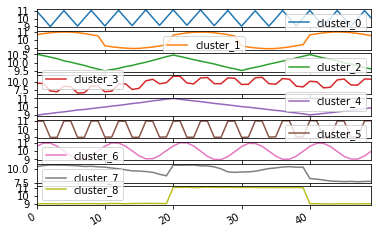

In [117]:
df.plot(subplots=True)
plt.show()

# Revenue

In [133]:
MODEL_PATH = "revenue/models/tcn_3_4_32_False_embed_True_dim_5"

In [134]:
from revenue.model import TCN
from revenue.data import RevenueDataset
import torch
import pandas as pd
from torch.utils.data import DataLoader
import pickle
import numpy as np

In [135]:
# Read in model
model = TCN(
        num_layers=3,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[32]*3,
        kernel_size=4,
        num_embeddings=dataset.num_ts,
        embedding_dim=5,
        embed='post',
        dilated_convolutions=False,
        )
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

[1, 1, 1]


TCN(
  (tcn): TemporalConvolutionalNetwork(
    (net): Sequential(
      (0): ResidualBlock(
        (dcc1): DilatedCausalConv(1, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
        (res_conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
      )
      (2): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop1): Dropout(p=0.5, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(4,), stride=(1,))
        (drop2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (conv1d): DilatedCausalConv(32, 1, 

In [136]:
dataset = RevenueDataset(
    file_path="revenue\data\processed_companies.csv",
    meta_path="revenue\data\comp_sect_meta.csv",
    start_date="2007-01-01",
    end_date="2017-01-01",
    receptive_field=10,
)
dataloader = DataLoader(dataset=dataset, batch_size=1, num_workers=0, shuffle=False)

Dimension of X :  torch.Size([15229, 1, 40])
Dimension of Y :  torch.Size([15229, 1, 40])


In [137]:
embeddings = {}
for i, d in enumerate(dataloader):
    x, y, idx, idx_row = d[0], d[1], d[2], d[3]
    embeddings[idx_row.item()] = model.embedding(idx_row).detach().numpy().flatten()

In [146]:
df = pd.DataFrame(embeddings).T

In [148]:
X = df.values

In [150]:
kmeans = KMeans(n_clusters=5, random_state=0, verbose=1)

In [151]:
kmeans.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3926.593
start iteration
done sorting
end inner loop
Iteration 1, inertia 3685.367
start iteration
done sorting
end inner loop
Iteration 2, inertia 3639.3977
start iteration
done sorting
end inner loop
Iteration 3, inertia 3624.7954
start iteration
done sorting
end inner loop
Iteration 4, inertia 3616.026
start iteration
done sorting
end inner loop
Iteration 5, inertia 3608.856
start iteration
done sorting
end inner loop
Iteration 6, inertia 3604.8103
start iteration
done sorting
end inner loop
Iteration 7, inertia 3603.161
start iteration
done sorting
end inner loop
Iteration 8, inertia 3602.4285
start iteration
done sorting
end inner loop
Iteration 9, inertia 3601.987
start iteration
done sorting
end inner loop
Iteration 10, inertia 3601.8223
start iteration
done sorting
end inner loop
Iteration 11, inertia 3601.6497
start iteration
done sorting
end inner loop
Iteration 12, inertia 3601.6135
star

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=1)

In [155]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 13812, 1: 83, 2: 734, 3: 320, 4: 280}

In [160]:
centers = kmeans.cluster_centers_
centers

array([[-0.00851668,  0.008539  ,  0.00853179,  0.00852728, -0.00883073],
       [ 4.7979693 , -4.800581  , -4.7984242 , -4.797398  ,  4.8014326 ],
       [ 0.803577  , -0.80412316, -0.80324644, -0.8034221 ,  0.8040591 ],
       [ 2.2729163 , -2.272933  , -2.273255  , -2.2734115 ,  2.2735462 ],
       [-1.7936461 ,  1.7949408 ,  1.7928853 ,  1.7930126 , -1.7936875 ]],
      dtype=float32)

In [164]:
dists = kmeans.transform(X)
dists

array([[ 0.03386259, 10.724083  ,  1.79003   ,  5.0759172 ,  4.017928  ],
       [ 0.01798834, 10.753912  ,  1.8198277 ,  5.1057367 ,  3.9880857 ],
       [ 0.04005142, 10.784172  ,  1.8501208 ,  5.1360016 ,  3.9578543 ],
       ...,
       [ 0.06603713, 10.689829  ,  1.7558354 ,  5.041675  ,  4.052234  ],
       [ 0.01941595, 10.761155  ,  1.8270594 ,  5.1129785 ,  3.9808335 ],
       [ 0.04028175, 10.783338  ,  1.8493083 ,  5.135165  ,  3.9586933 ]],
      dtype=float32)

In [190]:
np.argsort(dists[:, 2])[::-1][:10].tolist()

[3088, 14834, 2008, 5904, 13922, 15078, 5930, 1797, 14387, 8921]

In [199]:
prots = dataset.X[(np.argsort(dists[:, 4])[::-1][:10].tolist())].reshape(10,-1).detach().numpy()

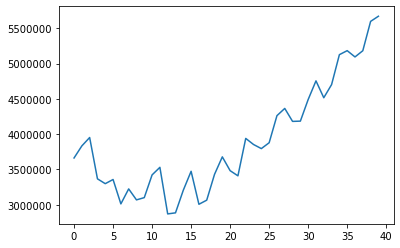

In [200]:
plt.plot(np.true_divide(prots.sum(0),(prots!=0).sum(0)))

In [206]:
approx_proto = []
for c in range(dists.shape[1]):
    print(c)
    prots = dataset.X[(np.argsort(dists[:, c])[::-1][:10].tolist())].reshape(10,-1).detach().numpy()
    approx_proto.append(np.true_divide(prots.sum(0),(prots!=0).sum(0)))
approx_proto

0
1
2
3
4


[array([3662458.66666667, 3833380.66666667, 3952475.33333333,
        3366709.71428571, 3297989.71428571, 3357223.71428571,
        3011337.        , 3223695.5       , 3068086.5       ,
        3100205.5       , 3422245.        , 3529749.75      ,
        2869107.2       , 2884401.2       , 3205367.6       ,
        3473621.77777778, 3005774.8       , 3064032.8       ,
        3429961.2       , 3678092.8       , 3482429.6       ,
        3409216.        , 3939882.4       , 3853410.4       ,
        3795400.8       , 3878415.6       , 4262404.8       ,
        4364980.8       , 4181119.2       , 4184859.2       ,
        4491427.6       , 4755846.4       , 4516662.4       ,
        4702859.2       , 5127334.8       , 5184246.        ,
        5095249.6       , 5183163.6       , 5599249.6       ,
        5672260.8       ]),
 array([ 40189.        ,  38846.        ,  50272.        ,  43474.        ,
         39996.        ,  85384.        , 567369.375     , 549443.11111111,
        499205

In [207]:
d = {f"cluster_{i}" : l for i, l in enumerate(approx_proto)}

In [208]:
df = pd.DataFrame(d)
df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,3.662459e+06,40189.0,5462719.0,40189.0,3.662459e+06
1,3.833381e+06,38846.0,5716057.5,38846.0,3.833381e+06
2,3.952475e+06,50272.0,5891339.0,50272.0,3.952475e+06
3,3.366710e+06,43474.0,4686002.4,43474.0,3.366710e+06
4,3.297990e+06,39996.0,4589212.0,39996.0,3.297990e+06


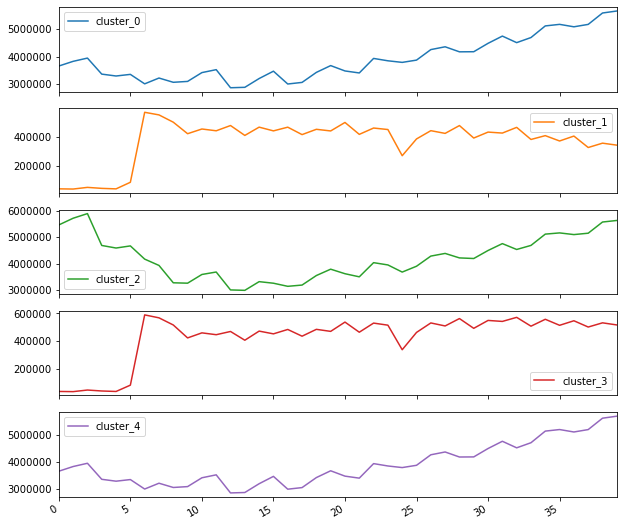

In [212]:
df.plot(figsize=(10,10), subplots=True)
plt.show()